# Wildcat vs ACME — MODFLOW-2005 (FloPy 3.9.5)

## 1) Imports

In [106]:
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoMinorLocator
import matplotlib.cm as cm
import flopy
import flopy.utils.binaryfile as bf

print(f"FloPy version: {flopy.__version__}")

FloPy version: 3.10.0


## 2) Main Directories Setup

In [107]:
# File paths
model_top_dir = "../HW_2"
input_dir = os.path.join(model_top_dir, "Model_Scenarios")
if not os.path.exists(input_dir):
    print("Creating workspace directory")
    os.makedirs(input_dir, exist_ok=True)

exe_name = "../../../../modflow/mf2005"         # MF2005 executable
assert os.path.exists(exe_name), f"mf2005 not found at: {exe_name}"

## 3) Discretization, BAS, and LPF Setup

In [108]:
# DIS
Lx = 4000.0                 # meters
Ly = 4000.0                 # meters
dx = dy = 50.0              # cell width in meters
nrow = int(Ly / dy)         # Number of rows
ncol = int(Lx / dx)         # Number of columns

nlay = 1                    # Number of layers
ztop = 250  #70             # Top of the model domain (m)
zbot = 0.0                  # Bottom of the model domain (m)
dz   = (ztop - zbot) / nlay # Thickness of each layer (m)

nper   = 1                  # Number of stress periods
perlen = [1.0]              # Length of each stress period in days
nstp   = [1]                # Number of time steps in each stress period
steady = [True]             # Steady-state (True) or transient (False) stress period flag
itmuni = 4                  # Time unit (4 = days)
lenuni = 2                  # Length unit (2 = meters)

# For Grid
x_centers = np.array([(c+0.5)*dx for c in range(ncol)])
y_centers = np.array([Ly - (r+0.5)*dy for r in range(nrow)])
r_mid = nrow // 2           # Row index of the middle row
c_mid = ncol // 2           # Column index of the middle column
SHIFT = (4000 - Lx) / 2.0   # Shift all coordinates by half the difference of (4000 - new size) if you change Lx/Ly from 4000 -- Use a negative if you increasse

# LPF
laytyp = 1                  # 0 = confined, >0 = unconfined
n  = 0.35                   # porosity
S = 0.001                   # storage coefficient for confined layers (if laytyp=0) or specific storage for unconfined layers (if laytyp>0)
Sy = 0.30                   # specific yield for unconfined layers (if laytyp>0) else 0.30 * dz  ???
Ss = 0.001                  # specific storage for confined layers (if laytyp=0) else 0.001 / dz ???

# BAS
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,0]  = -1         #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1         #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

## 4) Helpers Functions:
- (y,x) ↔ (row,col)
- (row,col) ↔ (y,x)
- Linear interpolation


In [109]:
def yx_to_rc(y, x):
    """
    Conversion from (y,x) coordinates to (row, column) indices in the model grid.
    """

    col = np.floor(x / dx).astype(np.int32)
    row = np.floor((Ly - y) / dy).astype(np.int32)
    if not (0 <= row < nrow and 0 <= col < ncol):
        raise ValueError(f"Point (y={y}, x={x}) outside model domain.")
    return row, col


def rc_to_yx(row, col):
    """
    Conversion from (row, column) indices in the model grid to (y,x) coordinates.
    """
    x = (col + 0.5) * dx
    y = Ly - (row + 0.5) * dy
    return y, x


def linear_interp(x, x0, v0, x1, v1):
    """
    Perform linear interpolation to find the value at x given two points (x0, v0) and (x1, v1).
    """
    if np.isclose(x1, x0):
        return 0.5*(v0+v1)
    return v0 + (v1 - v0) * ((x - x0) / (x1 - x0))

## 5) Setup Wells and Farms

In [110]:
acre_to_m2 = 4046.8564
inch_to_m = 0.0254
year_to_day = 365.0

obs = [{"name":"OW1", "y":3130-SHIFT, "x":806-SHIFT,  "dtw":4.8,  "K":1.5},
       {"name":"OW2", "y":774-SHIFT,  "x":750-SHIFT,  "dtw":5.4,  "K":13.0},
       {"name":"OW3", "y":3063-SHIFT, "x":3102-SHIFT, "dtw":50.2, "K":1.0},
       {"name":"OW4", "y":772-SHIFT,  "x":3250-SHIFT, "dtw":51.6, "K":8.4}]

# Convert DTW to head and add to obs dict: h = ztop - DTW
for o in obs:
    o["head"] = ztop - o["dtw"]

# WildCat farm: 30 acres, square
A_wild = 30.0 * acre_to_m2                      # WildCat Farm Area (m)
L_wild = np.sqrt(A_wild)                        # WildCat Farm Side Length (m)
wild_sw = (2250-SHIFT, 875-SHIFT)               # WeilCat Farm SW corner (y, x)
wild_center = (wild_sw[0] + L_wild/2, wild_sw[1] + L_wild/2)  # WildCat Farm Well location (y, x)
print(wild_center)
wild_well_yx = wild_center
wild_well_rc = yx_to_rc(wild_well_yx[0], wild_well_yx[1])
print(f"WildCat Well Locations (row,col): {wild_well_rc}")

# ACME farm: 500 acres, rectangular, 2:1 length to width ratio
A_acme = 500.0 * acre_to_m2                     # ACME Farm Area (m)
w_acme = np.sqrt(A_acme/2.0)                    # ACME Farm Width (m)
l_acme = 2.0*w_acme                             # ACME Farm Length (m)
acme_sw = (750-SHIFT, 1450-SHIFT)               # ACME Farm SW corner (y, x)

SCENARIO = ["baseline", "best", "worst"]
ACME_WELLS_YX = {                   # ACME Farm Well Location (y, x) per scneario
    "baseline": [(1400-SHIFT, 1950-SHIFT), (2100-SHIFT, 1950-SHIFT)],
    "best":     [(1100-SHIFT, 1650-SHIFT), (1100-SHIFT, 2250-SHIFT)],
    "worst":    [(2500-SHIFT, 1500-SHIFT), (2100-SHIFT, 1500-SHIFT)],
}
acme_wells_yx = [ACME_WELLS_YX[scen] for scen in SCENARIO]
ACME_WELLS_RC = {scen: [yx_to_rc(*pt) for pt in pts] for scen, pts in ACME_WELLS_YX.items()}
print(f"   ACME Well Locations (row,col): {ACME_WELLS_RC}\n")

# Pumping rates (m3/day)
Q_wild = round(41.2 * inch_to_m / year_to_day * A_wild, 4)
Q_acme = round(74.3 * inch_to_m / year_to_day * A_acme, 4)
Q_acme_each = round(Q_acme / 2.0 , 4)
Q_total = Q_wild + Q_acme

print(f"   WildCat Pumping Rate: {Q_wild:.2f}(m3/day)")
print(f"ACME Pumping Rate (per): {Q_acme_each:.2f}(m3/day)")

(np.float64(2424.2165979463493), np.float64(1049.2165979463496))
WildCat Well Locations (row,col): (np.int32(31), np.int32(20))
   ACME Well Locations (row,col): {'baseline': [(np.int32(52), np.int32(39)), (np.int32(38), np.int32(39))], 'best': [(np.int32(58), np.int32(33)), (np.int32(58), np.int32(45))], 'worst': [(np.int32(30), np.int32(30)), (np.int32(38), np.int32(30))]}

   WildCat Pumping Rate: 348.08(m3/day)
ACME Pumping Rate (per): 5231.03(m3/day)


## 6) Interpolate heads (H)

In [111]:
# Sorting for k and head interpolation
obs_sorted = sorted(obs, key=lambda d: d["y"])
south_pair = obs_sorted[:2]
north_pair = obs_sorted[2:]

sW, sE = sorted(south_pair, key=lambda d: d["x"])
nW, nE = sorted(north_pair, key=lambda d: d["x"])

y_south = 0.5*(sW["y"] + sE["y"])
y_north = 0.5*(nW["y"] + nE["y"])
denom_y = (y_north - y_south) if not np.isclose(y_north, y_south) else 1.0

# South and north boundary heads as a function of x (cell centers)
H_south_x = np.array([linear_interp(x, sW["x"], sW["head"], sE["x"], sE["head"]) for x in x_centers], dtype=np.float32)
H_north_x = np.array([linear_interp(x, nW["x"], nW["head"], nE["x"], nE["head"]) for x in x_centers], dtype=np.float32)

# Interpolate from south -> north for each row (y), then copy to all layers (z)
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
y0 = y_centers[0]
y1 = y_centers[-1]
den = (y1 - y0) if not np.isclose(y1, y0) else 1.0      # avoid divide-by-zero

for r, y in enumerate(y_centers):
    fy = (y - y0) / den                                 # 0 at first row in y_centers, 1 at last row in y_centers
    H_row = H_south_x + fy * (H_north_x - H_south_x)    # (ncol,)
    strt[:, r, :] = H_row                               # broadcast across all layers

west_bc = strt[0, :, 0]
east_bc = strt[0, :, -1]


# # Basic Model Heads Setup
# strt = np.zeros((nlay, nrow, ncol), dtype=np.float32)
# strt[:,:,:] = (west_bc + east_bc) / 2
# strt[0, :, 0] = west_bc
# strt[0, :, -1] = east_bc


# # For a mean single H value everywhere
# H_value = sum([o["head"] for o in obs]) / len(obs)
# strt = np.full((nlay, nrow, ncol), H_value, dtype=np.float32)
# strt[0, :, 0] = west_bc
# strt[0, :, -1] = east_bc


print(f"Head range West: {west_bc.min():3.2f} to {west_bc.max():3.2f} meters")
print(f"Head range East: {east_bc.min():3.2f} to {east_bc.max():3.2f} meters")
print(f"Head strt.shape: {strt.shape}")

Head range West: 258.00 to 260.64 meters
Head range East: 182.54 to 185.00 meters
Head strt.shape: (1, 80, 80)


## 7) Interpolate Hydraulic Conductivity (k)

In [112]:
ks = [o["K"] for o in obs]
k_min = min(ks)
k_max = max(ks)
K_south_x = np.array([linear_interp(x, sW["x"], sW["K"], sE["x"], sE["K"]) for x in x_centers])
K_north_x = np.array([linear_interp(x, nW["x"], nW["K"], nE["x"], nE["K"]) for x in x_centers])

hk = np.zeros((nlay, nrow,ncol), dtype=np.float32)
for r, y in enumerate(y_centers):
    wy = np.clip((y - y_south)/denom_y, 0.0, 1.0)
    hk[:, r,:] = K_south_x + wy*(K_north_x - K_south_x)


# # for Basic Model - K's in quadrants Setup
# hk = np.zeros((nlay, nrow, ncol), dtype=np.float32)
# hk[:, :r_mid, :c_mid] = obs[0]["K"]      # upper left
# hk[:, :r_mid, c_mid:] = obs[1]["K"]      # upper right
# hk[:, r_mid:, :c_mid] = obs[2]["K"]      # lower left
# hk[:, r_mid:, c_mid:] = obs[3]["K"]      # lower right


# For a mean single K value everywhere
k_value = sum([o["K"] for o in obs]) / len(obs)
hk = np.full((nlay, nrow, ncol), 1, dtype=np.float32)


print(f"K range:  {hk.min():.2f} to {hk.max():.2f} m/day")
print(f"K mean:  {np.mean(hk):.2f} m/day")
print(f"hk shape: {hk.shape}")

K range:  1.00 to 1.00 m/day
K mean:  1.00 m/day
hk shape: (1, 80, 80)


## 8) Calculate Recharge

In [113]:
def rect_mask(sw_yx, length_y, width_x):
    y_sw, x_sw = sw_yx
    y_ne = y_sw + length_y
    x_ne = x_sw + width_x

    mask = np.zeros((nrow, ncol), dtype=bool)
    for r in range(nrow):
        for c in range(ncol):
            y, x = rc_to_yx(r, c)
            mask[r, c] = (y >= y_sw) and (y <= y_ne) and (x >= x_sw) and (x <= x_ne)
    return mask

# For masking out recharge areas
wild_mask = rect_mask(wild_sw, L_wild, L_wild)
acme_mask = rect_mask(acme_sw, l_acme, w_acme)

R_background = 1e-4
R_farm_extra = -1e-4    # set to negative to erase any farm recharge
frac_return = 0.00      # set to zero to erase any farm recharge

R_return_wild = (frac_return * Q_wild) / A_wild
R_return_acme = (frac_return * Q_acme) / A_acme

rech = np.full((nrow, ncol), R_background, dtype=np.float32)
rech[wild_mask] += R_farm_extra + R_return_wild
rech[acme_mask] += R_farm_extra + R_return_acme
cell_area = dx * dy
active2d = (ibound[0, :, :] > 0)   # top layer active cells
rech_total = np.sum(rech[active2d] * cell_area)

print(f"Total Recharge: {rech_total}")
print(f"Wildcat farm recharge (m/day): {round((R_background + R_farm_extra + R_return_wild), 6)}")
print(f"ACME farm recharge (m/day): {round((R_background + R_farm_extra + R_return_acme), 6)}")

Total Recharge: 1347.75
Wildcat farm recharge (m/day): 0.0
ACME farm recharge (m/day): 0.0


## 9) Build MODFLOW models

In [114]:
def build_model(modelname, model_ws, exe_name, wel_data_sp0=None, version="mf2005", wells=True):
    m   = flopy.modflow.Modflow(modelname=modelname, model_ws=model_ws, exe_name=exe_name, version=version)
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, delr=dx, delc=dy, top=ztop, botm=zbot, itmuni=itmuni, lenuni=2, nper=nper, perlen=perlen, nstp=nstp, steady=steady)
    bas = flopy.modflow.ModflowBas(model=m, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(model=m, laytyp=laytyp, hk=hk, vka=1, ss=Ss, sy=Sy, storagecoefficient=True, ipakcb=53)
    rch = flopy.modflow.ModflowRch(model=m, rech=rech, ipakcb=53)
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data={0: wel_data_sp0}) if wells else None
    # pcg = flopy.modflow.ModflowPcg(model=m)
    pcg = flopy.modflow.ModflowPcg(model=m, rclose=1e-4, relax=0.98)
    oc  = flopy.modflow.ModflowOc(model=m, stress_period_data={(0,0):['print head', 'print budget', 'save head', 'save budget']}, compact=True)

    m.write_input()
    return m


In [115]:
import inspect
print(f"Defaults for package: {inspect.signature(flopy.modflow.ModflowPcg)}")

Defaults for package: (model, mxiter=50, iter1=30, npcond=1, hclose=1e-05, rclose=1e-05, relax=1.0, nbpol=0, iprpcg=0, mutpcg=3, damp=1.0, dampt=1.0, ihcofadd=0, extension='pcg', unitnumber=None, filenames=None)


## 10) Write and Build Scenarios

In [116]:
no_wells = "Wildcat_No_Wells"
main_name = "Wildcat_main"
wel_data_sp0 = []
models = []

# For No Well Base Model
nope = os.path.join(input_dir, no_wells)
if not os.path.exists(nope):
    print("Creating workspace directory")
    os.makedirs(nope, exist_ok=True)

basic = build_model(no_wells, nope, exe_name, wells=False)
models.append(basic)


#For WildCat Well Only Model
wildcat = os.path.join(input_dir, main_name)
if not os.path.exists(wildcat):
    print("Creating workspace directory")
    os.makedirs(wildcat, exist_ok=True)

layer = 0
wild_well = [layer, wild_well_rc[0], wild_well_rc[1], -Q_wild]
wel_data_sp0.append(wild_well)

main = build_model(main_name, wildcat, exe_name, wel_data_sp0)
models.append(main)


# For Acme Wells and WildCat Well Models
for scen, wells_rc in ACME_WELLS_RC.items():
    wel_data_sp0 = [wild_well]

    scen_name = f"Wildcat_{scen}"
    acme = os.path.join(input_dir, scen_name)
    os.makedirs(acme, exist_ok=True)

    for r, c in wells_rc:
        wel_data_sp0.append([layer, r, c, -Q_acme_each])
    
    sc = build_model(scen_name, acme, exe_name, wel_data_sp0)
    models.append(sc)

## 11) Run Model

In [117]:
for m in models:
    success, buff = m.run_model(silent=False, report=True)
    print("Run success:", success)

    if not success:
        print(f"{'='*75}\n{'-'*30} MODFLOW FAILED {'-'*29}\n{'='*75}")

FloPy is using the following executable to run the model: ../../../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Wildcat_No_Wells.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/14  4:33:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/14  4:33:18
 Elapsed run time:  0.068 Seconds

  Normal termination of simulation
Run success: True
FloPy is using the following executable to run the model: ../../../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Wildcat_main.nam 
 Run start date and tim

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/14  4:33:18
 Elapsed run time:  0.074 Seconds

  Normal termination of simulation
Run success: True
FloPy is using the following executable to run the model: ../../../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Wildcat_best.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/14  4:33:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/14  4:33:18
 Elapsed run time:  0.088 Seconds

  Normal termination of simulation
Run success: True
FloPy is using the following executable to run the model: ../../../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER

## 12) Model Setup Map Plotting

In [126]:
def plot_map(fig, ax, model, array2d=None, title="", cmap="viridis", cbar_label=None, layer=0, plot_grid=False, alpha=1, clim=None):
    """
    Plot a 2D array on the model grid using flopy's PlotMapView.
    """
    modelmap = flopy.plot.PlotMapView(model=model, ax=ax, layer=layer)
    if plot_grid:
        modelmap.plot_grid(linewidth=0.1, alpha=0.5)

    plot_kwargs = {"cmap": cmap, "alpha": alpha}
    if clim is not None:
        plot_kwargs["vmin"], plot_kwargs["vmax"] = clim
        levels = np.linspace(np.nanmin(array2d), np.nanmax(array2d), 8)
        cs =modelmap.contour_array(array2d, levels=levels, linewidths=1.5, zorder=9)
        txts = ax.clabel(cs, inline=True, inline_spacing=3, fontsize=10, fmt="%.2f")
        for t in txts:
            t.set_bbox(dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.75, pad=1.25))
        y, x = wild_center
        ax.scatter(x, y, marker="o", s=25, facecolor="grey", edgecolor="black", linewidth=1.5, zorder=10, label="Wildcat well")
        ax.legend()

    im = modelmap.plot_array(array2d, **plot_kwargs)

    fig.colorbar(im, ax=ax, shrink=0.9, label=cbar_label)
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    return im


def base_map(ax, model, title="Base Map"):
    """
    Plot the base map with grid, ibound, and well/observation locations.
    """
    modelmap = flopy.plot.PlotMapView(model=model, ax=ax, layer=0)
    modelmap.plot_grid(linewidth=0.1)
    modelmap.plot_ibound()
    # modelmap.plot_bc(ftype='WEL')
    
    hd =f"Constant Heads  (m)\nWest: {west_bc.max():.0f} to {west_bc.min():.0f} (N to S)\nEast:    {east_bc.max():.0f} to {east_bc.min():.0f}   (N to S)"
    ibound_handles = [mp.patches.Patch(facecolor="blue",  edgecolor="black", label=hd)]
    
    # Observation wells
    ax.scatter([o["x"] for o in obs], [o["y"] for o in obs], s=20, color="grey", edgecolors="k",label="Obs wells")
    for o in obs:
        obw = f"{o['name']}\nDTW: {o['dtw']}m\nK: {o['K']:.1f}"
        ax.text(o["x"] + 15, o["y"] - 250, s=obw, color="k", fontsize=10)

    # Pumping wells
    ax.scatter([wild_center[1]], [wild_center[0]], marker="*", s=80, color="red", edgecolors="darkblue", linewidths=0.75, label="Wildcat well")
    aw = ["orange","green","red"]
    for i, scen in enumerate(SCENARIO):
        acme_wells = ACME_WELLS_YX[scen]
        ax.scatter([x for (y, x) in acme_wells], [y for (y, x) in acme_wells], s=80, marker="*", color=aw[i], edgecolors="black", linewidths=0.75, label=f"ACME wells ({scen})")

    # WildCat Farm
    y0, x0 = wild_sw
    ax.plot([x0, x0+L_wild, x0+L_wild, x0, x0], [y0, y0, y0+L_wild, y0+L_wild, y0], color="red", linewidth=2, label="Wildcat")

    # ACME Farm
    y0a, x0a = acme_sw
    ax.plot([x0a, x0a+w_acme, x0a+w_acme, x0a, x0a], [y0a, y0a, y0a+l_acme, y0a+l_acme, y0a], color="orange", linewidth=2, label="ACME")

    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)

    leg1 = ax.legend(loc="upper right", frameon=True)
    leg2 = ax.legend(handles=ibound_handles, loc="upper center", frameon=True, ncol=3)
    # Keep both legends
    ax.add_artist(leg1)

    ax.set_aspect("equal", adjustable="box")
    # plt.tight_layout()
    return modelmap

## 13) Plot Model Setups

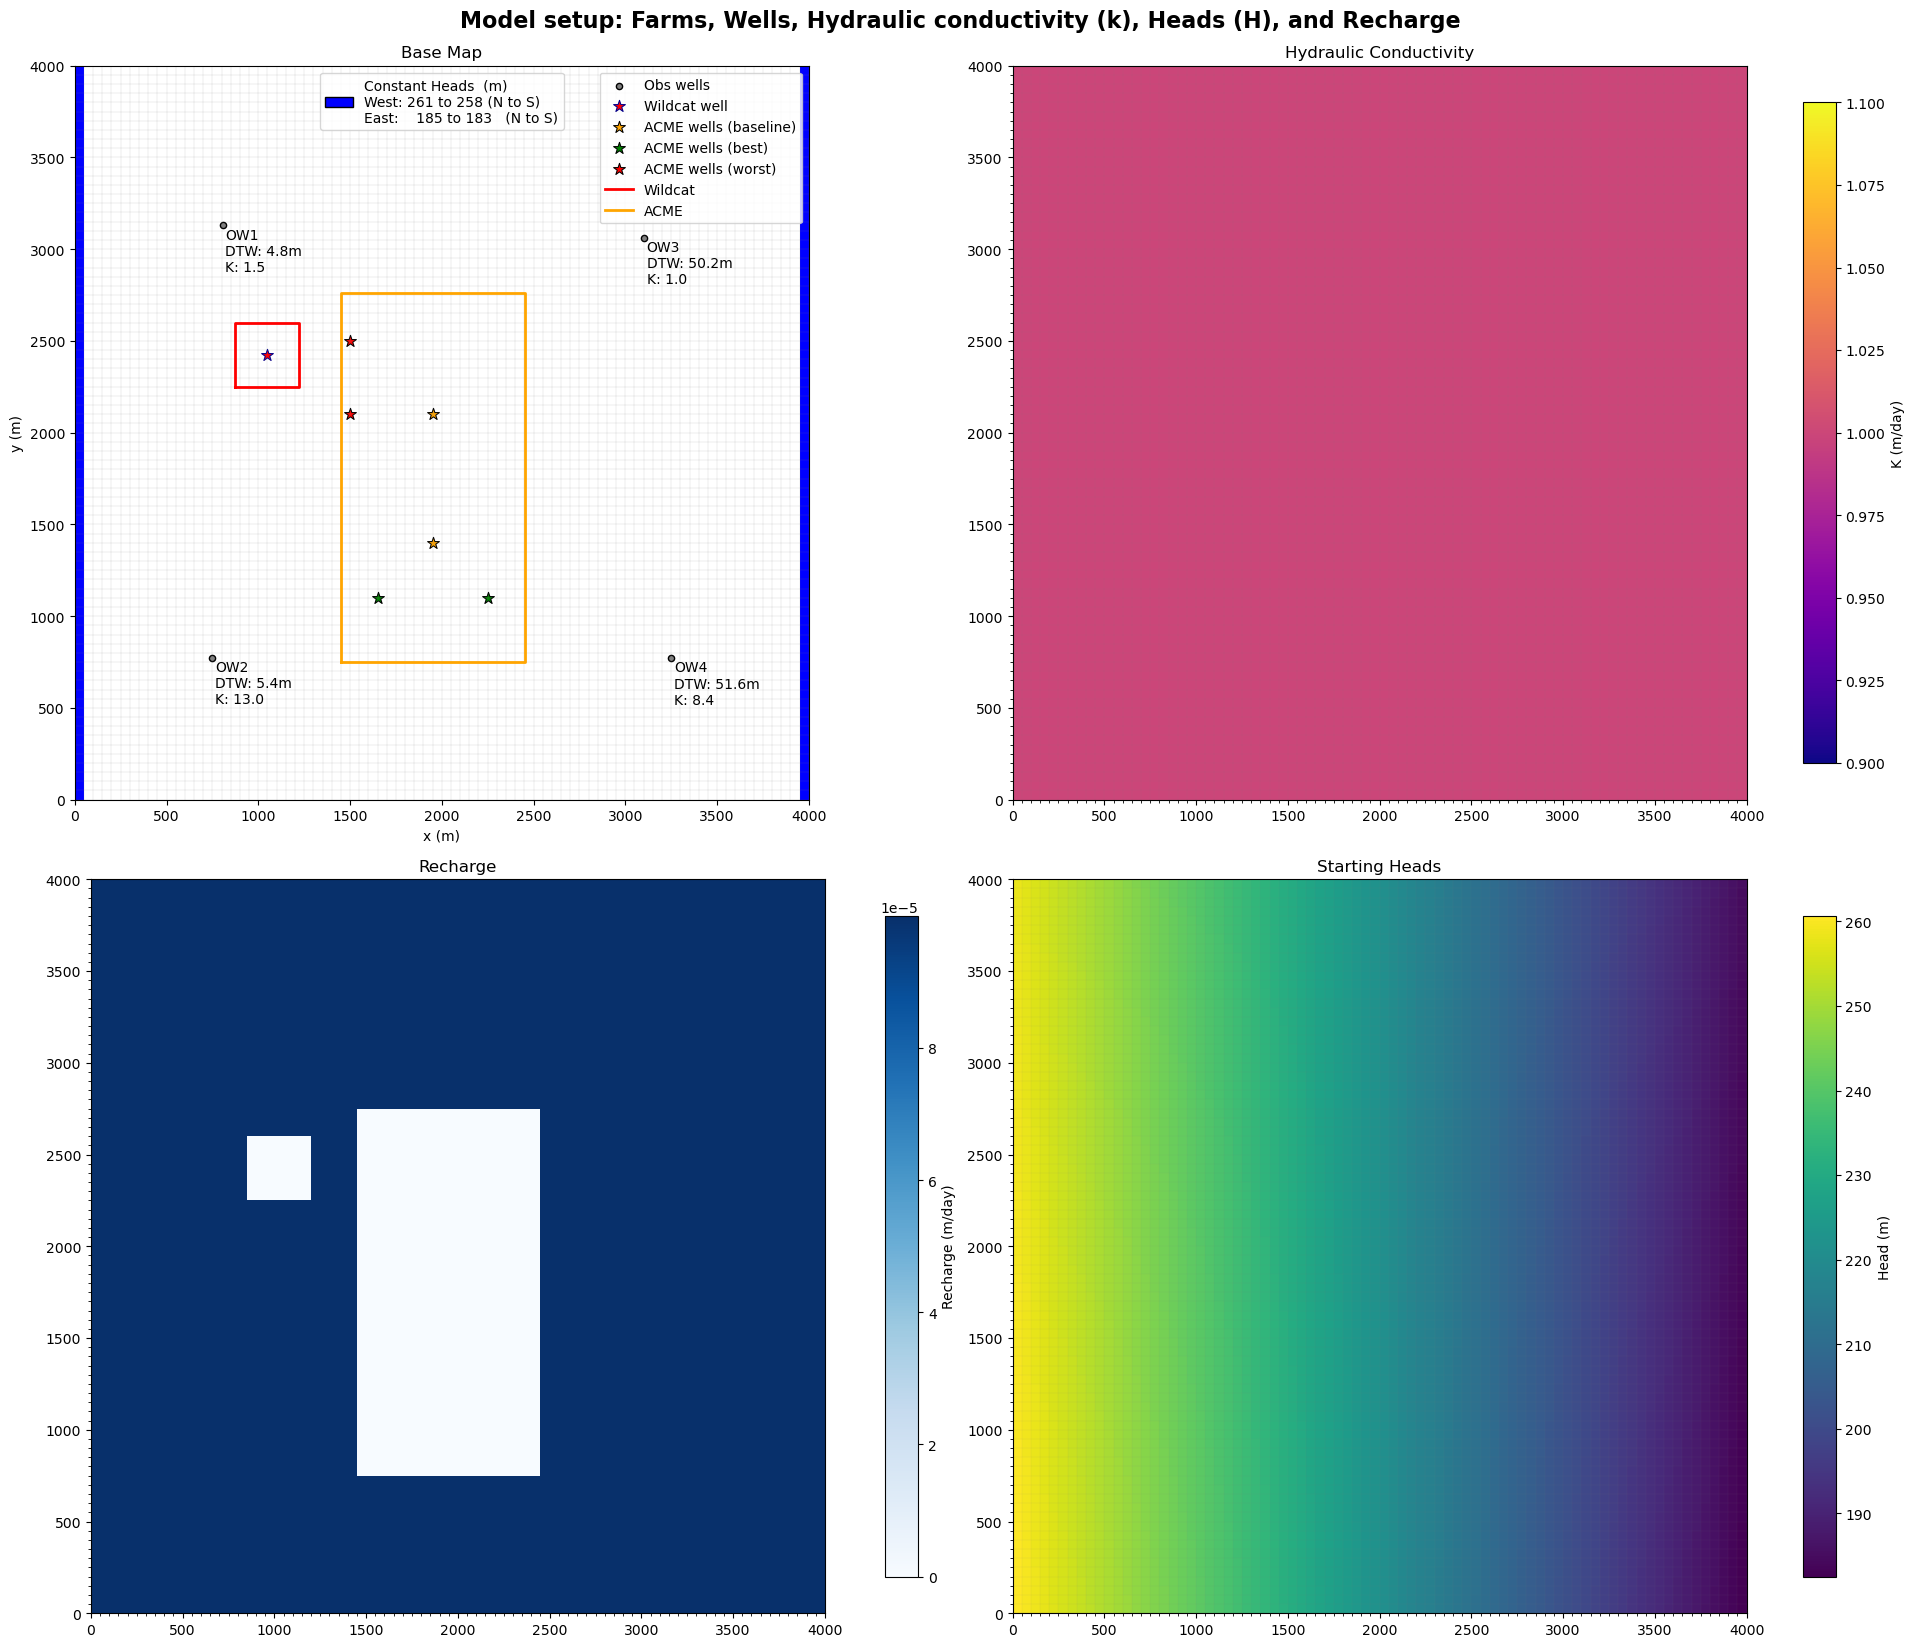

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(19, 16), constrained_layout=True, squeeze=False)
fig.suptitle("Model setup: Farms, Wells, Hydraulic conductivity (k), Heads (H), and Recharge", fontsize=16, fontweight="bold", y=1.02)
ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

titles = ("Base Map with Farms and Wells", "Recharge", "Hydraulic Conductivity", "Starting Heads")
cbars  = ("Recharge (m/day)", "K (m/day)", "Head (m)")

# Base map goes on ax1
base_map(ax1, models[2])

# Array plots
plot_map(fig, ax2, m, array2d=hk,   title=titles[2], cmap="plasma", cbar_label=cbars[1], plot_grid=True)
plot_map(fig, ax3, m, array2d=rech, title=titles[1], cmap="Blues",  cbar_label=cbars[0], plot_grid=False)
plot_map(fig, ax4, m, array2d=strt, title=titles[3], cbar_label=cbars[2], plot_grid=True)

# Set extents consistently (since you did not share axes)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_aspect("equal", adjustable="box")

plt.show()


## 14) Get Heads for all models

In [120]:
scenarios = ["No_Wells", "main", "baseline", "best", "worst"]
head_arrays = {}
for scen in scenarios:
    hds_path = os.path.join(input_dir, f"Wildcat_{scen}", f"Wildcat_{scen}.hds")
    if not os.path.exists(hds_path):
        print("Heads file not found:", hds_path)
        continue

    hds = flopy.utils.HeadFile(hds_path)
    head = hds.get_data(kstpkper=(0, 0))   # shape (nlay,nrow,ncol) or (nrow,ncol)
    head = head[0, :, :]

    head_arrays[scen] = head

print(f"Head LeveL at WildCat Well -  Pre Dev: {head_arrays['No_Wells'][31,20]:.2f}")
print(f"Head LeveL at WildCat Well -  WC Only: {head_arrays['main'][31,20]:.2f}\n{'-'*45}")
print(f"Head LeveL at WildCat Well - Baseline: {head_arrays['baseline'][31,21]:.2f}")
print(f"Head LeveL at WildCat Well -    Worst: {head_arrays['worst'][31,20]:.2f}")
print(f"Head LeveL at WildCat Well -     Best: {head_arrays['best'][31,20]:.2f}\n{'='*45}")
print(f"DTW at WildCat Well -  Pre Dev: {dz-head_arrays['No_Wells'][31,20]:.2f}")
print(f"DTW at WildCat Well -  WC Only: {dz-head_arrays['main'][31,20]:.2f}\n{'-'*45}")
print(f"DTW at WildCat Well - Baseline: {dz-head_arrays['baseline'][31,21]:.2f}")
print(f"DTW at WildCat Well -    Worst: {dz-head_arrays['worst'][31,20]:.2f}")
print(f"DTW at WildCat Well -     Best: {dz-head_arrays['best'][31,20]:.2f}")

Head LeveL at WildCat Well -  Pre Dev: 242.63
Head LeveL at WildCat Well -  WC Only: 241.41
---------------------------------------------
Head LeveL at WildCat Well - Baseline: 234.62
Head LeveL at WildCat Well -    Worst: 230.93
Head LeveL at WildCat Well -     Best: 237.26
DTW at WildCat Well -  Pre Dev: 7.37
DTW at WildCat Well -  WC Only: 8.59
---------------------------------------------
DTW at WildCat Well - Baseline: 15.38
DTW at WildCat Well -    Worst: 19.07
DTW at WildCat Well -     Best: 12.74


## 15) Plot Drawdowns for scenarios

Drawdown max for baseline: -28.75 meters
Drawdown at WildCat well: -5.96
----------------------------------------
Drawdown max for best: -31.37 meters
Drawdown at WildCat well: -4.15
----------------------------------------
Drawdown max for worst: -28.89 meters
Drawdown at WildCat well: -10.49
----------------------------------------


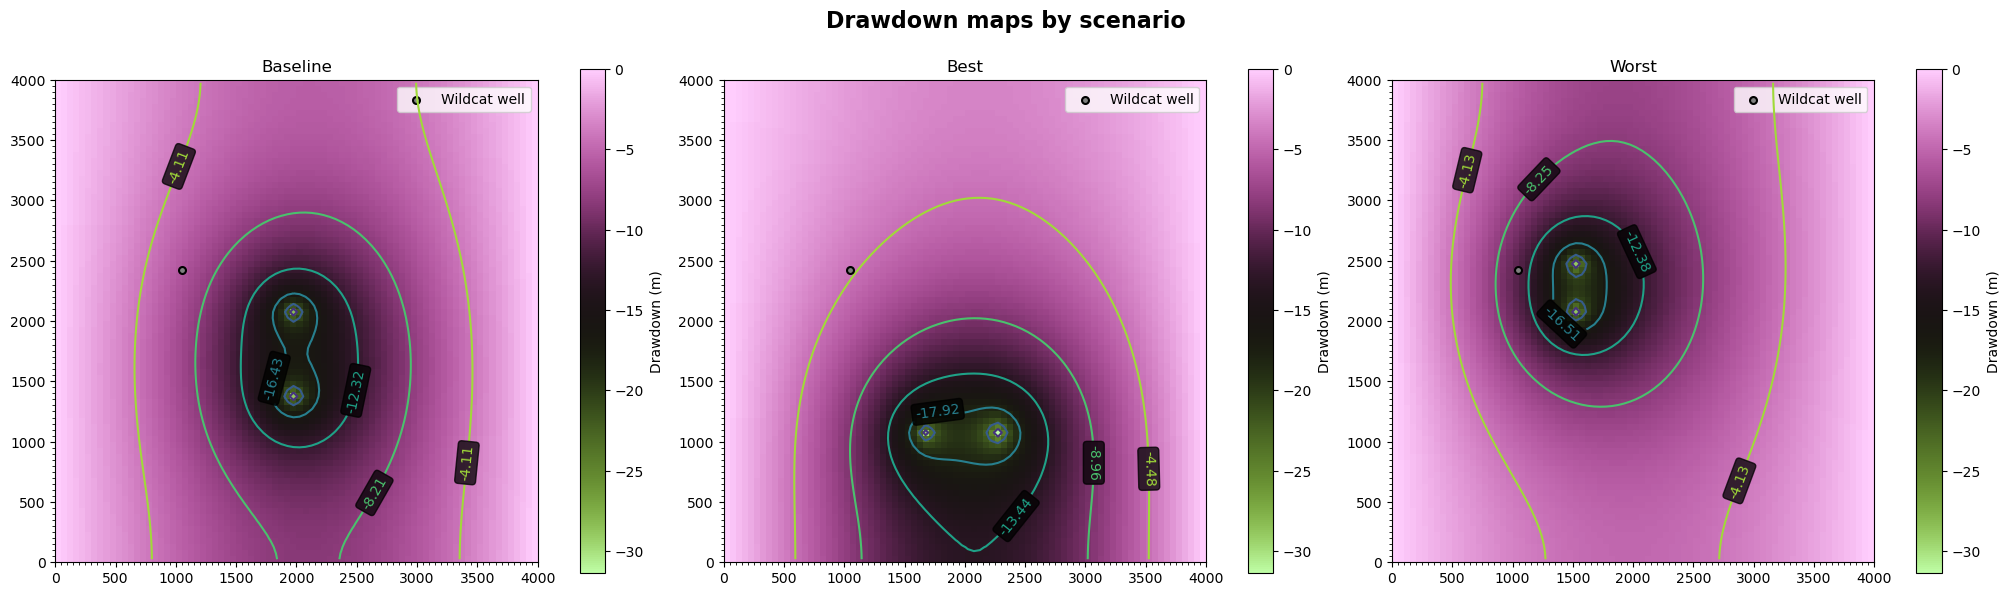

In [127]:
pre = head_arrays["No_Wells"]
main_head = head_arrays["main"]
drawdowns = {}
for scen in SCENARIO:
    drawdowns[scen] = head_arrays[scen] - main_head

vmin = min(np.nanmin(dd) for sc in drawdowns.values() for dd in sc.flatten())
vmax = max(np.nanmax(dd) for sc in drawdowns.values() for dd in sc.flatten())
clim = (vmin, vmax)

for scen, dd in drawdowns.items():
    print(f"Drawdown max for {scen}: {dd.min():.2f} meters")
    print(f"Drawdown at WildCat well: {dd[31,20]:.2f}\n{'-'*40}")

fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
fig.suptitle("Drawdown maps by scenario", fontsize=16, fontweight="bold")

cmap = "vanimo_r"
plot_map(fig, axs[0], m, array2d=drawdowns["baseline"], title="Baseline", cmap=cmap, cbar_label="Drawdown (m)", clim=clim)
plot_map(fig, axs[1], m, array2d=drawdowns["best"],     title="Best",     cmap=cmap, cbar_label="Drawdown (m)", clim=clim)
plot_map(fig, axs[2], m, array2d=drawdowns["worst"],    title="Worst",    cmap=cmap, cbar_label="Drawdown (m)", clim=clim)

ax.set_aspect("equal", adjustable="box")
plt.show()

## 16) Steady-State Head Surface by Scenario

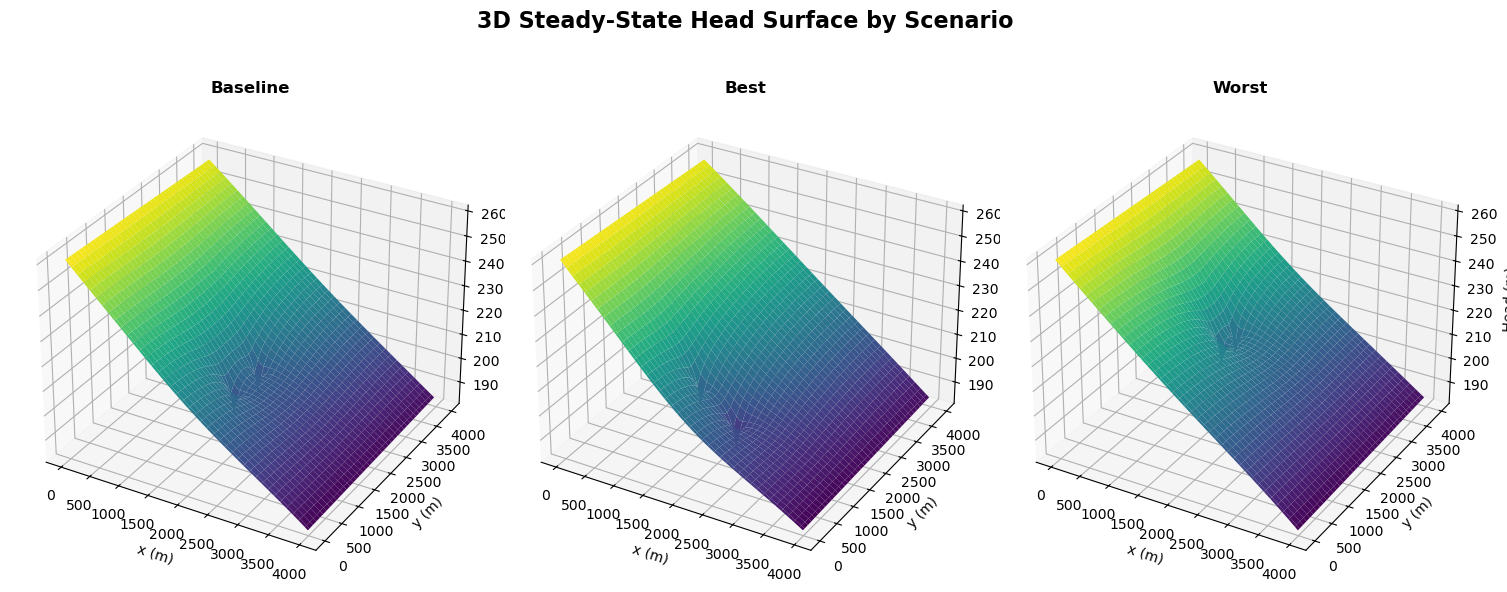

In [122]:
sc_list = [2, 3, 4]  # 2=Baseline, 3=Best, 4=Worst
sc_titles = {2: "Baseline", 3: "Best", 4: "Worst"}

heads = []
XY = []

for sc in sc_list:
    m_sc = models[sc]
    model_path = os.path.join(input_dir, f"Wildcat_{scenarios[sc]}", f"Wildcat_{scenarios[sc]}")
    headobj = bf.HeadFile(model_path + ".hds")
    times = headobj.get_times()
    head_sc = headobj.get_data(totim=times[-1])  # (nlay,nrow,ncol)

    heads.append(head_sc)
    XY.append((m_sc.modelgrid.xcellcenters, m_sc.modelgrid.ycellcenters))

# shared color limits across scenarios
hmin = np.nanmin([np.nanmin(h[0]) for h in heads])
hmax = np.nanmax([np.nanmax(h[0]) for h in heads])
norm = Normalize(vmin=hmin, vmax=hmax)
cmap = plt.get_cmap("viridis")

fig = plt.figure(figsize=(15, 6))
fig.suptitle("3D Steady-State Head Surface by Scenario", fontsize=16, fontweight="bold", y=1.02)

for i, sc in enumerate(sc_list, start=1):
    ax = fig.add_subplot(1, 3, i, projection="3d")
    X, Y = XY[i-1]
    Z = heads[i-1][0]

    surf = ax.plot_surface(X, Y, Z, cmap=cmap, norm=norm, linewidth=0, antialiased=True)

    ax.set_title(sc_titles[sc], fontsize=12, fontweight="bold")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("Head (m)")

# one shared colorbar for all three
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

plt.tight_layout()
plt.show()


## 17) Boundary Face Flows by Scenario

Scenario: Baseline
Left Flux = 21794.195 
Right_flux = 12331.803
Difference = 9462.393
Pumping = 10810.145
Recharge = 1347.750
∆Storage = -0.002 ... Steady State!!!

Scenario: Best
Left Flux = 21794.21 
Right_flux = 12331.816
Difference = 9462.395
Pumping = 10810.145
Recharge = 1347.750
∆Storage = 0.000 ... Steady State!!!

Scenario: Worst
Left Flux = 22986.07 
Right_flux = 13523.678
Difference = 9462.393
Pumping = 10810.145
Recharge = 1347.750
∆Storage = -0.002 ... Steady State!!!



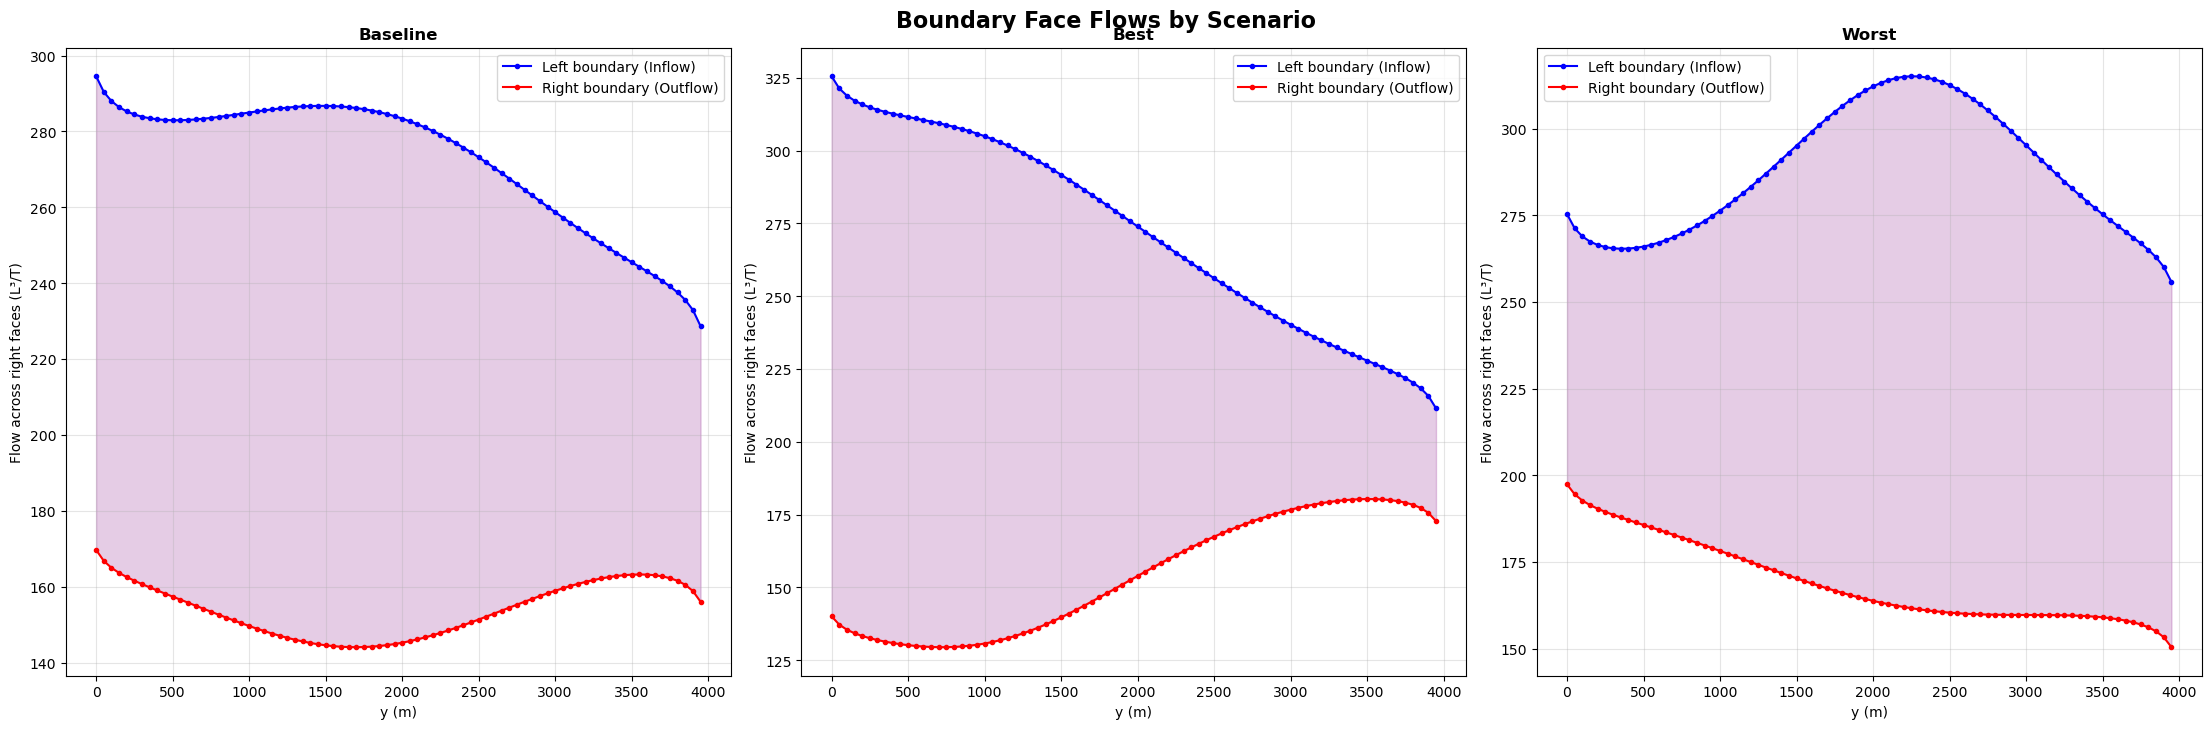

In [123]:
sc_list = [2, 3, 4] 
sc_titles = {2: "Baseline", 3: "Best", 4: "Worst"}

fig, axs = plt.subplots(1, 3, figsize=(22, 7), constrained_layout=True)
fig.suptitle("Boundary Face Flows by Scenario", fontsize=16, fontweight="bold", y=1.02)

for ax, sc in zip(axs, sc_list):
    m_sc = models[sc]
    model_path = os.path.join(input_dir, f"Wildcat_{scenarios[sc]}", f"Wildcat_{scenarios[sc]}")
    budgobj = bf.CellBudgetFile(model_path + ".cbc")

    kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
    frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
    fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells   

    flux_vals = np.squeeze(frf)
    leftflux = flux_vals[:,0]
    rightflux = flux_vals[:,-2]  # Made negate to better visualize outflow as flow leaving the system

    x = np.arange(0, ncol * dx, dx)[::-1]  

    ax.plot(x, leftflux,  marker="o", markersize=3, linestyle="-", color='blue',  label="Left boundary (Inflow)")
    ax.plot(x, rightflux, marker="o", markersize=3, linestyle="-",color='red', label="Right boundary (Outflow)")
    ax.fill_between(x, leftflux, rightflux, where=(leftflux >= rightflux), interpolate=True, color='purple', alpha=0.2)  #, label='Pumping - Recharge')   #???

    ax.grid(alpha=0.33)
    ax.set_title(sc_titles[sc], fontsize=12, fontweight="bold")
    ax.set_xlabel("y (m)")
    ax.set_ylabel("Flow across right faces (L³/T)")
    ax.legend(loc="best", frameon=True)

    # Calculate the total flux across the right and left side of the domain 
    # See that the difference matches the pumping rate
    print(f"Scenario: {sc_titles[sc]}")
    right_tot = np.sum(rightflux)   # Note the units of this are L3/T
    left_tot = np.sum(leftflux)

    difference = left_tot - right_tot
    storage = difference - Q_total + rech_total
    print('Left Flux =', left_tot, "\nRight_flux =", right_tot)
    print(f"Difference = {difference:.3f}\nPumping = {Q_total:.3f}\nRecharge = {rech_total:.3f}")
    print(f"∆Storage = {storage:.3f} ... Steady State!!!\n" if abs(storage) <= 1 else f"∆Storage = {storage:.3f} ... Not Steady State :(\n")



plt.show()


## 18) Steady-State Model: Head Contours & Specific Discharge

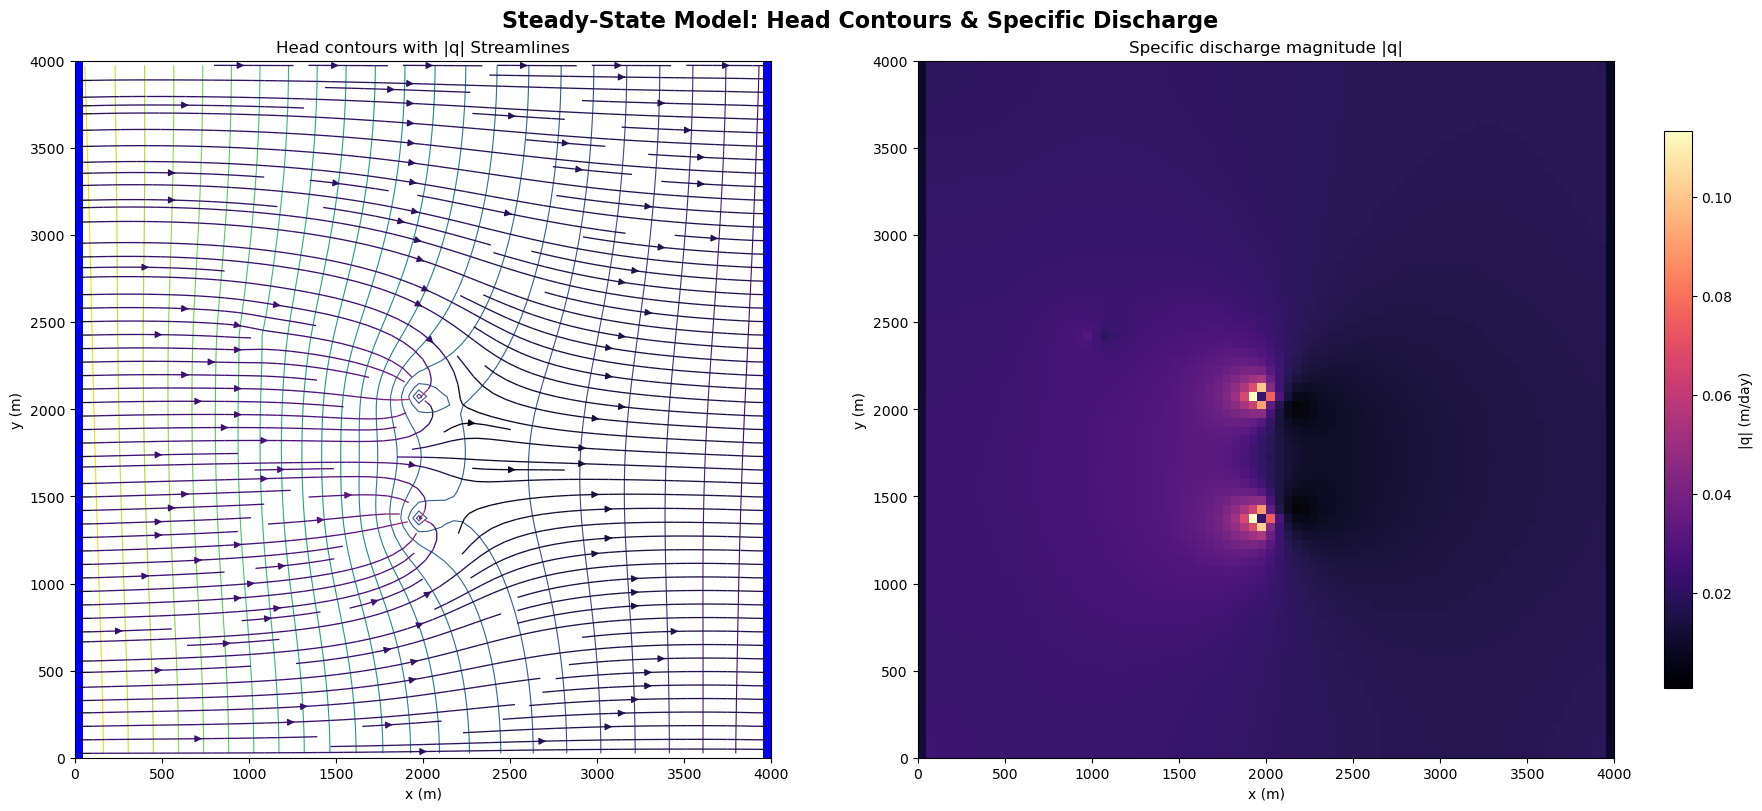

In [124]:
sc = 2
m = models[sc]
lay = 0

model_path = os.path.join(input_dir, f"Wildcat_{scenarios[sc]}", f"Wildcat_{scenarios[sc]}")
budgobj = bf.CellBudgetFile(model_path + ".cbc")
headobj = bf.HeadFile(model_path + ".hds")

totim = headobj.get_times()[-1]
head  = headobj.get_data(totim=totim)

# Specific discharge (qx, qy) from face flows
frf = budgobj.get_data(text="FLOW RIGHT FACE", totim=totim)[0]
fff = budgobj.get_data(text="FLOW FRONT FACE", totim=totim)[0]

qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf, fff, None), m, head=head)
qx_lay = qx[lay] if qx.ndim == 3 else qx
qy_lay = qy[lay] if qy.ndim == 3 else qy

# Speed (|q|) field on the original grid (for the right panel + global vmin/vmax)
speed_map = np.sqrt(qx_lay**2 + qy_lay**2)

Xc = m.modelgrid.xcellcenters
Yc = m.modelgrid.ycellcenters
x = Xc[0, :].copy()
y = Yc[:, 0].copy()

U = qx_lay.copy()
V = qy_lay.copy()

# Ensure x & y (below) are strictly increasing
if np.any(np.diff(x) <= 0):
    ix = np.argsort(x)
    x = x[ix]
    U = U[:, ix]
    V = V[:, ix]


if np.any(np.diff(y) <= 0):
    y = y[::-1]
    U = U[::-1, :]
    V = V[::-1, :]

# Speed on the streamplot grid orientation 
speed_stream = np.sqrt(U**2 + V**2)

vmin, vmax = np.nanmin(speed_map), np.nanmax(speed_map)

cmap = plt.get_cmap("magma")
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot
fig, (axL, axR) = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
fig.suptitle("Steady-State Model: Head Contours & Specific Discharge", fontsize=16, fontweight="bold")


# ===== LEFT: Head contours & streamlines =====
pmvL = flopy.plot.PlotMapView(model=m, ax=axL, layer=lay)
pmvL.plot_ibound()
# pmvL.plot_bc(ftype='WEL')

levels = np.linspace(np.nanmin(head[lay]), np.nanmax(head[lay]), 25)
pmvL.contour_array(head[lay], levels=levels, linewidths=0.8)

sp = axL.streamplot(x, y, U, V, color=speed_stream, cmap=cmap, norm=norm, density=1.75, linewidth=0.95)

axL.set_title(f"Head contours with |q| Streamlines")
axL.set_xlabel("x (m)")
axL.set_ylabel("y (m)")
axL.set_aspect("equal", adjustable="box")

# ===== RIGHT: |q| magnitude map =====
pmvR = flopy.plot.PlotMapView(model=m, ax=axR, layer=lay)
pmvR.plot_ibound()

im = pmvR.plot_array(speed_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.85)

axR.set_title(f"Specific discharge magnitude |q|")
axR.set_xlabel("x (m)")
axR.set_ylabel("y (m)")
axR.set_aspect("equal", adjustable="box")

# ===== Shared colorbar ===== Use a ScalarMappable so the colorbar matches the shared norm/cmap
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=[axL, axR], shrink=0.8, pad=0.02)
cbar.set_label("|q| (m/day)")

plt.show()


## 19) Steady-State Model Specific Discharge Vectors and Head Gradient with Contour Lines

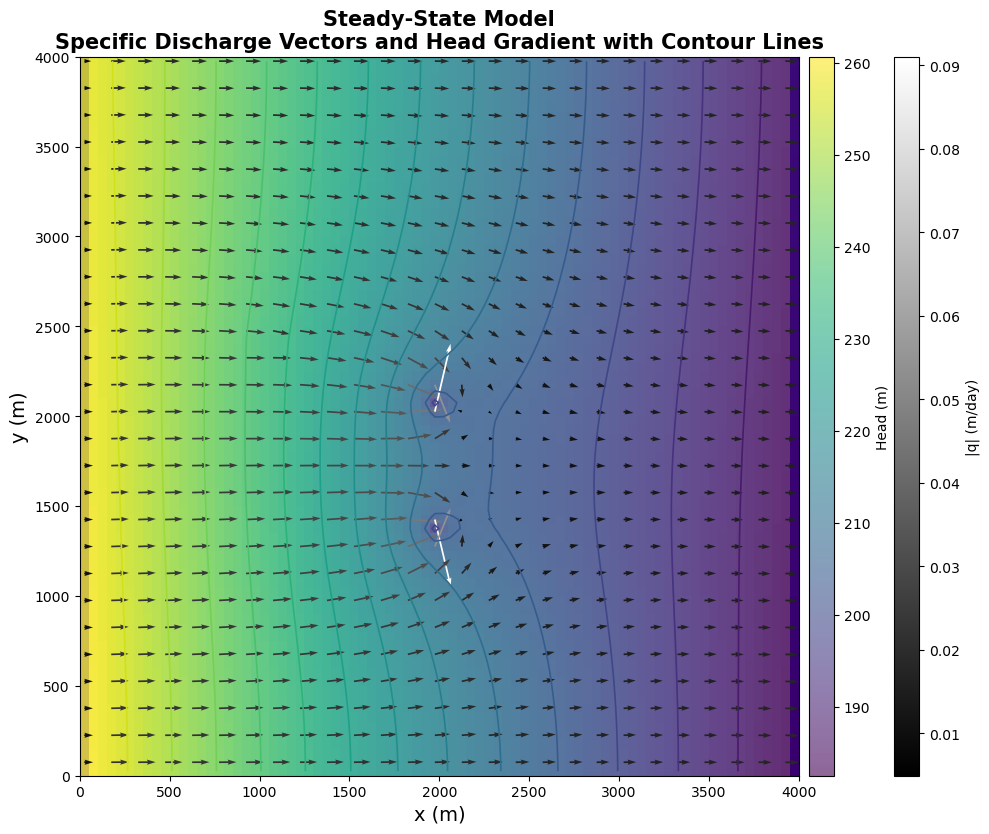

In [125]:
# Get model time units (MODFLOW-2005 DIS.ITMUNI)
itmuni_map = {0: "unknown", 1: "s", 2: "min", 3: "hr", 4: "day", 5: "yr"}
itmuni = getattr(m.dis, "itmuni", 0)  # MODFLOW-2005
tunit = itmuni_map.get(itmuni, "unknown")

lay = 0
istep, jstep = 3, 3

qx_lay = qx[lay] if qx.ndim == 3 else qx
qy_lay = qy[lay] if qy.ndim == 3 else qy
qmag   = np.sqrt(qx_lay**2 + qy_lay**2)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
modelmap = flopy.plot.PlotMapView(model=m, ax=ax, layer=lay)
modelmap.plot_ibound()

# Head background and head colorbar
im_head = modelmap.plot_array(head[lay], alpha=0.6)

# Head contours (2D)
levels = np.linspace(np.nanmin(head[lay]), np.nanmax(head[lay]), 15)
modelmap.contour_array(head[lay], levels=levels, linewidths=1.2)

# Downsample for vectors
X = m.modelgrid.xcellcenters
Y = m.modelgrid.ycellcenters
Xds = X[::istep, ::jstep]
Yds = Y[::istep, ::jstep]
Uds = qx_lay[::istep, ::jstep]
Vds = qy_lay[::istep, ::jstep]
Cds = qmag[::istep, ::jstep]

# Colored quiver + discharge colorbar (magma)
qv = ax.quiver(Xds, Yds, Uds, Vds, Cds, cmap="binary_r")

# Two colorbars on the right
divider = make_axes_locatable(ax)

cax1 = divider.append_axes("right", size="3.5%", pad=0.10)
cbar1 = fig.colorbar(im_head, cax=cax1)
cbar1.set_label("Head (m)")

cax2 = divider.append_axes("right", size="3.5%", pad=0.60)
cbar2 = fig.colorbar(qv, cax=cax2)
cbar2.set_label(f"|q| (m/{tunit})")

ax.set_aspect("equal", adjustable="box")

ax.set_xlabel("x (m)", fontsize=14)
ax.set_ylabel("y (m)", fontsize=14)
ax.set_title("Steady-State Model\nSpecific Discharge Vectors and Head Gradient with Contour Lines", fontsize=15, fontweight="bold")

plt.tight_layout()
plt.show()